In [4]:
import pickle
pkl_path = "/home/elahe/user/elahe/TRACTOR/logs/SingleUE/prev_experiments/dataset__emuc__Trial1_Trial2_Trial3_Trial4_Trial5_Trial6__slice16.pkl"

with open(pkl_path, "rb") as f:
    obj = pickle.load(f)      # loads whatever Python object was saved

print(type(obj))


<class 'dict'>


In [6]:
print(obj.keys())

dict_keys(['train', 'valid'])


In [7]:
obj

{'train': {'samples': {'no_norm': tensor([[[1.8544e+01, 1.1400e+02, 0.0000e+00,  ..., 0.0000e+00,
             6.0300e+02, 1.0000e+00],
            [1.0769e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00,
             1.8000e+01, 1.0000e+00],
            [1.2114e+01, 3.5000e+01, 0.0000e+00,  ..., 0.0000e+00,
             8.4000e+01, 1.0000e+00],
            ...,
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 1.0000e+00],
            [8.0000e+00, 4.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             3.0000e+00, 1.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 1.0000e+00]],
   
           [[4.5920e+00, 8.7500e+02, 1.2325e+05,  ..., 1.2500e+04,
             4.5000e+03, 1.0000e+00],
            [5.6240e+00, 8.7500e+02, 1.2639e+05,  ..., 1.2500e+04,
             4.5000e+03, 1.0000e+00],
            [5.1097e+00, 8.7500e+02, 1.2533e+05,  ..., 1.2500e+04,
             4.5000e+03, 1.0000e+00],
  

In [8]:
import torch, numpy as np

def show_tree(o, indent=""):
    if isinstance(o, dict):
        for k, v in o.items():
            t = type(v).__name__
            shape = getattr(v, "shape", None)
            length = (len(v) if hasattr(v, "__len__") and not isinstance(v, (str, bytes)) else None)
            extra = f" shape={tuple(shape)}" if shape is not None else (f" len={length}" if length is not None else "")
            print(f"{indent}{k}: {t}{extra}")
            # go down only one or two levels to avoid huge dumps
            if isinstance(v, dict):
                show_tree(v, indent + "  ")

show_tree(obj)


train: dict len=2
  samples: dict len=2
    no_norm: Tensor shape=(80963, 16, 17)
    norm: Tensor shape=(80963, 16, 17)
  labels: Tensor shape=(80963,)
valid: dict len=2
  samples: dict len=2
    no_norm: Tensor shape=(20241, 16, 17)
    norm: Tensor shape=(20241, 16, 17)
  labels: Tensor shape=(20241,)


### Time plots

In [34]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/home/elahe/user/elahe/TRACTOR/logs/SingleUE/Trial1/Raw/embb1010123456002_metrics.csv")

# Convert timestamp (assuming ms since epoch) to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# Sort by time to ensure correct order
df = df.sort_values('Timestamp').reset_index(drop=True)

print(df[['Timestamp']].head())


                Timestamp
0 2022-10-30 20:59:40.378
1 2022-10-30 20:59:40.628
2 2022-10-30 20:59:40.878
3 2022-10-30 20:59:41.128
4 2022-10-30 20:59:41.378


In [22]:
# Calculate time difference between consecutive samples
df['time_diff'] = df['Timestamp'].diff().dt.total_seconds()

print(df['time_diff'].describe())
print("Unique intervals:", df['time_diff'].unique())


count    10020.000000
mean         0.365444
std          5.400969
min          0.250000
25%          0.250000
50%          0.250000
75%          0.250000
max        411.250000
Name: time_diff, dtype: float64
Unique intervals: [       nan 2.5000e-01 1.9850e+02 8.3000e+01 4.0750e+01 7.3250e+01
 4.1125e+02 1.6500e+01 1.0000e+00 7.6500e+01 2.5375e+02 2.0000e+00
 3.0000e+00]


In [23]:
df['time_diff']

0         NaN
1        0.25
2        0.25
3        0.25
4        0.25
         ... 
10016    0.25
10017    0.25
10018    0.25
10019    0.25
10020    0.25
Name: time_diff, Length: 10021, dtype: float64

In [25]:
print(len(df['time_diff']))

10021


In [24]:
# Define expected interval and tolerance
expected_interval = 0.25
tolerance = 1e-6  # allow for small floating-point errors

# Find irregular intervals within tolerance range
irregular_rows = df[df['time_diff'].notna() & (abs(df['time_diff'] - expected_interval) > tolerance)]

print(f"Number of irregular intervals: {len(irregular_rows)}")
print(irregular_rows[['Timestamp', 'time_diff']])

Number of irregular intervals: 11
                   Timestamp  time_diff
373  2022-10-30 21:04:31.878     198.50
624  2022-10-30 21:06:57.378      83.00
1864 2022-10-30 21:12:47.878      40.75
2387 2022-10-30 21:16:11.628      73.25
6265 2022-10-30 21:39:12.128     411.25
7007 2022-10-30 21:42:33.878      16.50
7251 2022-10-30 21:43:35.628       1.00
7495 2022-10-30 21:45:52.878      76.50
8092 2022-10-30 21:52:35.628     253.75
8337 2022-10-30 21:53:38.628       2.00
9457 2022-10-30 21:58:21.378       3.00


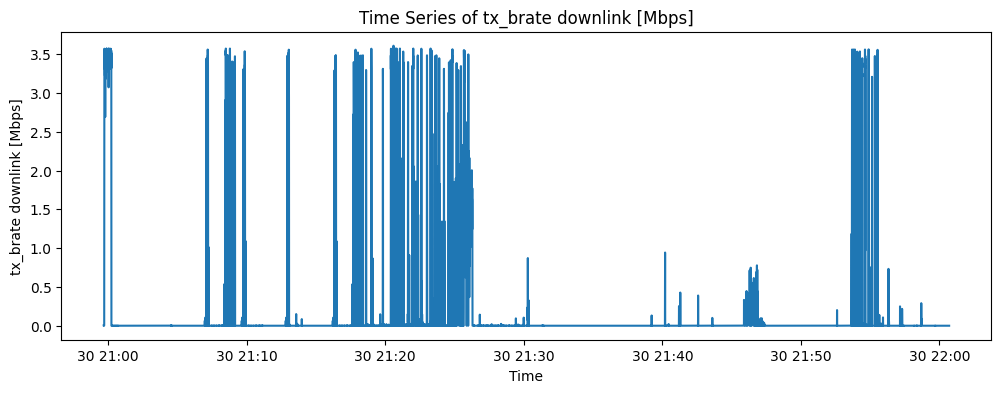

In [35]:
import matplotlib.pyplot as plt

kpi_col = "tx_brate downlink [Mbps]"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()


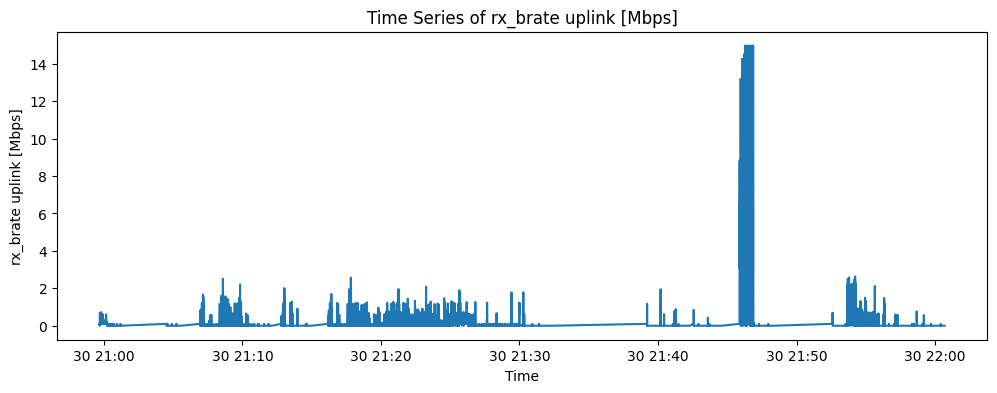

In [26]:
kpi_col = "rx_brate uplink [Mbps]"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()


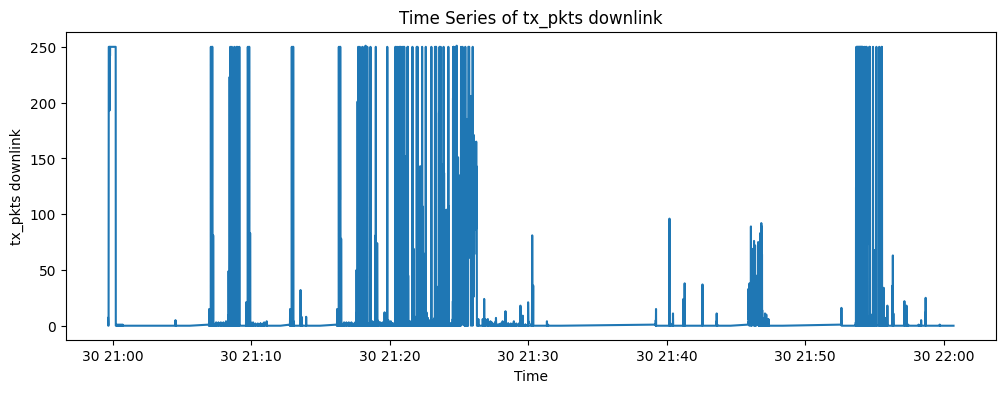

In [27]:
kpi_col = "tx_pkts downlink"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()


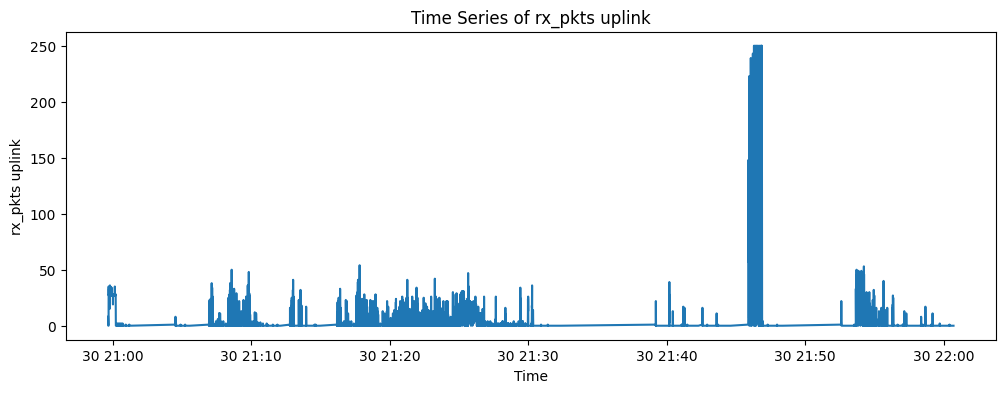

In [28]:
kpi_col = "rx_pkts uplink"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()


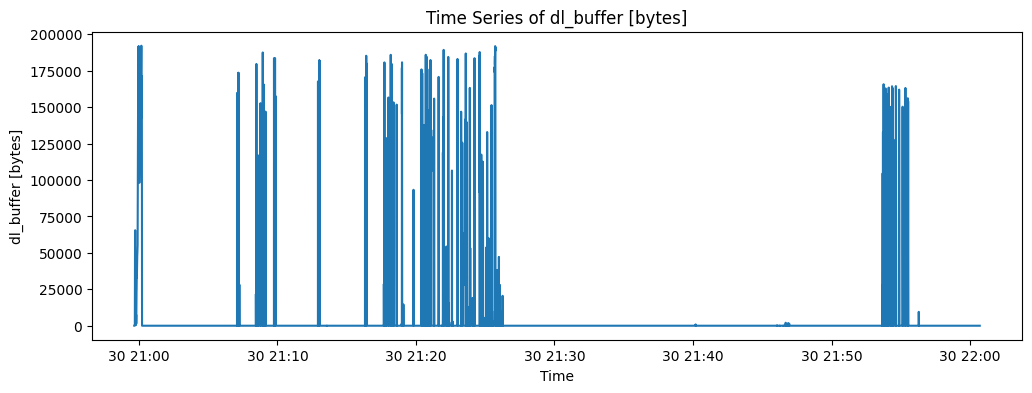

In [29]:
kpi_col = "dl_buffer [bytes]"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()

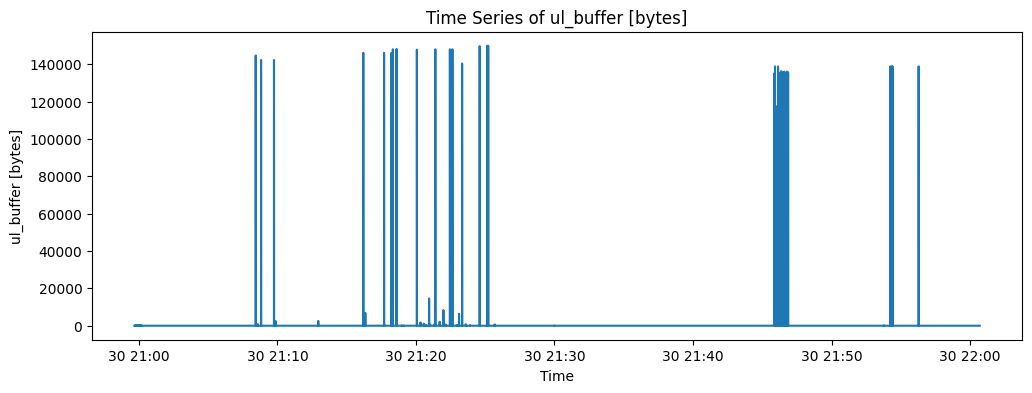

In [30]:
kpi_col = "ul_buffer [bytes]"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()

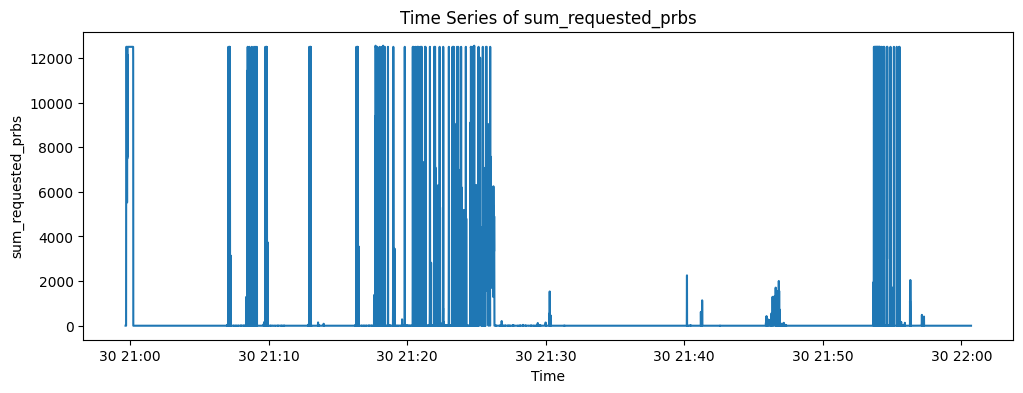

In [31]:
kpi_col = "sum_requested_prbs"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()

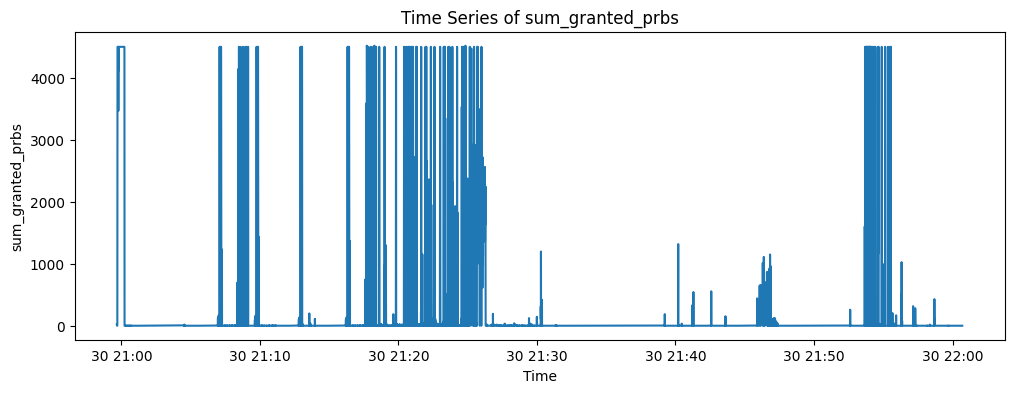

In [32]:
kpi_col = "sum_granted_prbs"  # Choose your KPI column
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df[kpi_col])
plt.title(f"Time Series of {kpi_col}")
plt.xlabel("Time")
plt.ylabel(kpi_col)
plt.show()

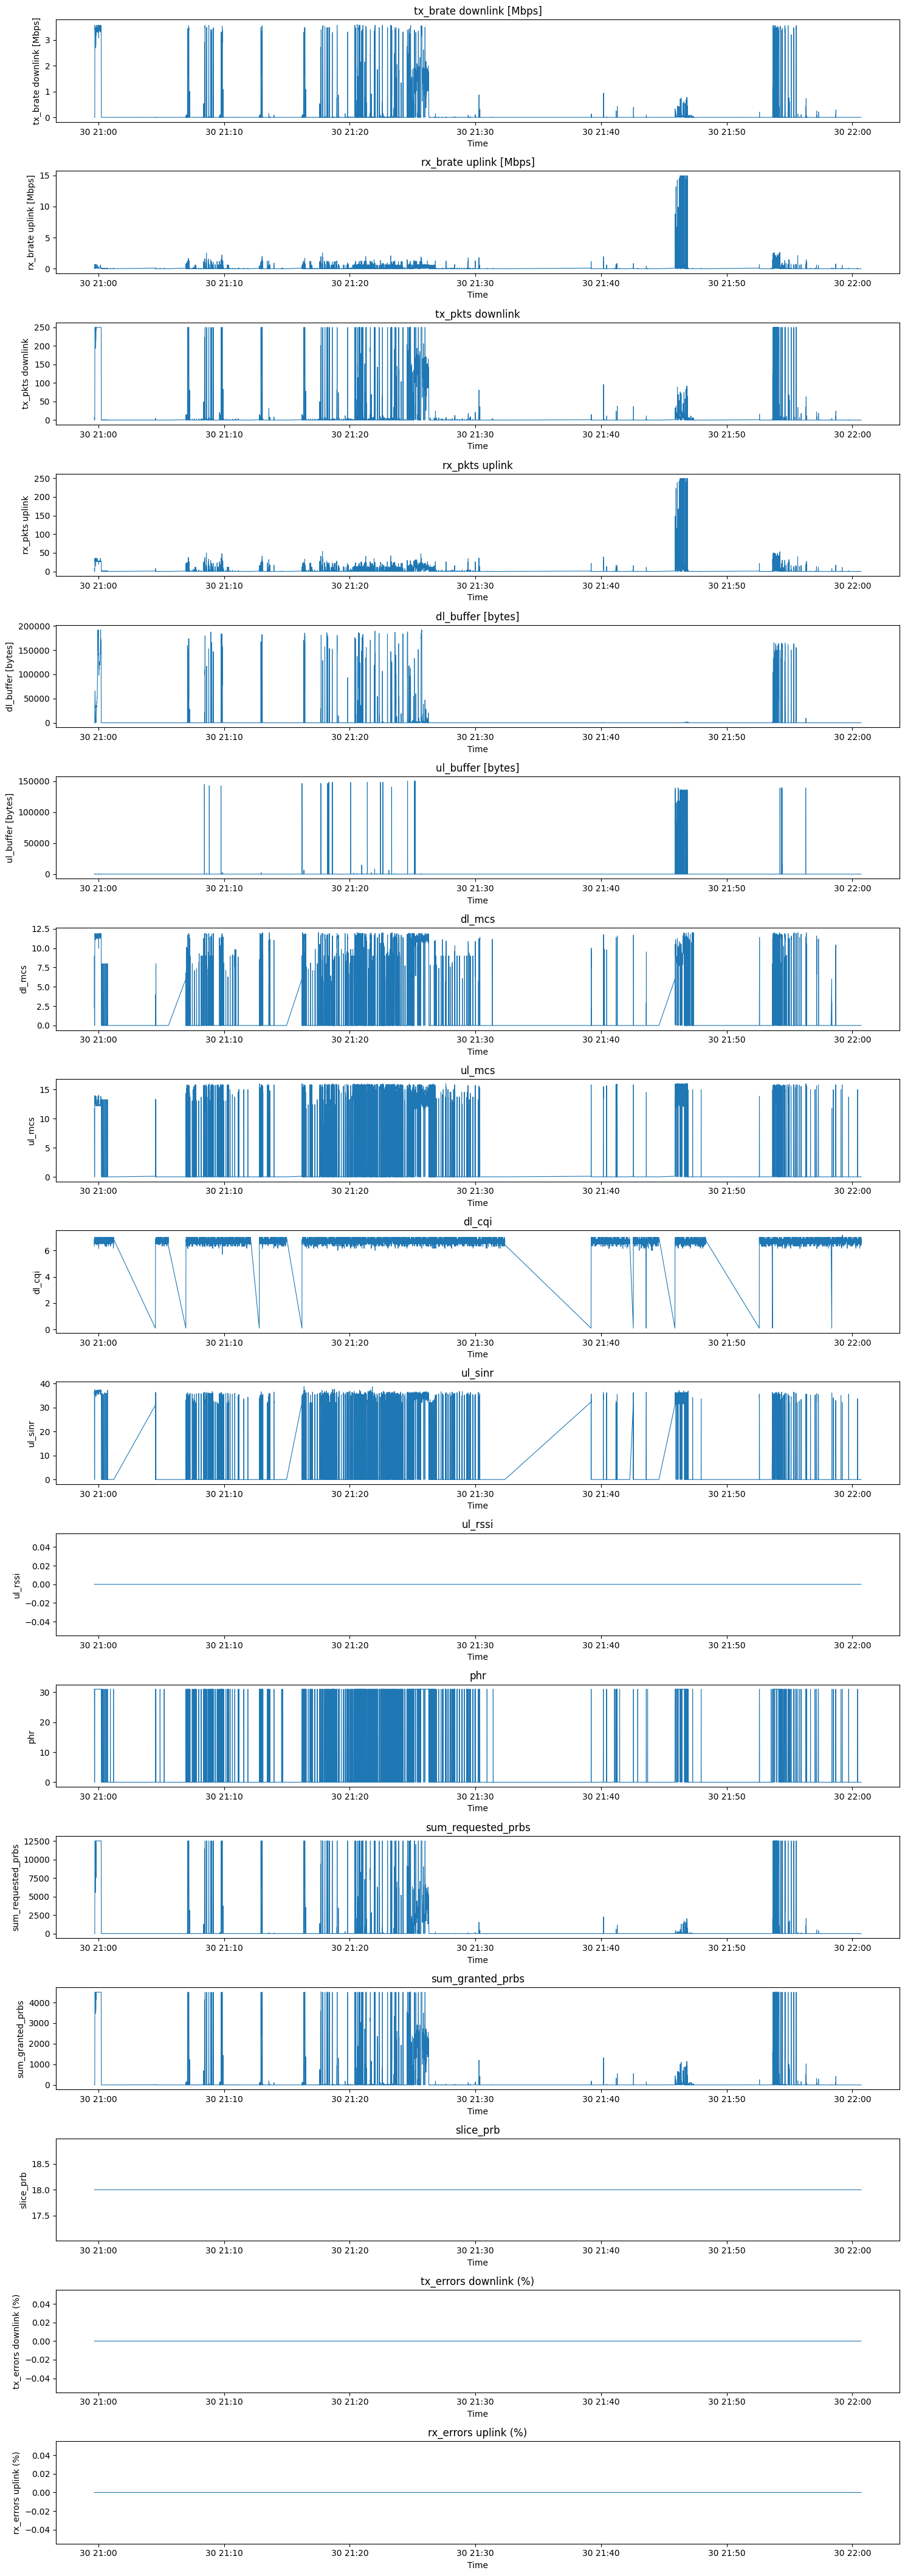

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
#df = pd.read_csv("embb1010123456002_metrics.csv")

# Convert timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# List of KPIs to plot
kpi_columns = [
    # Traffic demand & usage
    'tx_brate downlink [Mbps]',
    'rx_brate uplink [Mbps]',
    'tx_pkts downlink',
    'rx_pkts uplink',
    'dl_buffer [bytes]',
    'ul_buffer [bytes]',
    
    # Link quality
    'dl_mcs',
    'ul_mcs',
    'dl_cqi',
    'ul_sinr',
    'ul_rssi',
    'phr',
    
    # Resource allocation
    'sum_requested_prbs',
    'sum_granted_prbs',
    'slice_prb',
    
    # Error rates
    'tx_errors downlink (%)',
    'rx_errors uplink (%)'
]

# Plot each KPI over time
plt.figure(figsize=(15, len(kpi_columns) * 2.5))
for i, col in enumerate(kpi_columns, 1):
    plt.subplot(len(kpi_columns), 1, i)
    plt.plot(df['Timestamp'], df[col], linewidth=0.8)
    plt.title(col)
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.tight_layout()

plt.show()


In [ ]:
#df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# Define KPI categories
traffic_kpis = [
    'tx_brate downlink [Mbps]',
    'rx_brate uplink [Mbps]',
    'tx_pkts downlink',
    'rx_pkts uplink',
    'dl_buffer [bytes]',
    'ul_buffer [bytes]'
]

link_quality_kpis = [
    'dl_mcs',
    'ul_mcs',
    'dl_cqi',
    'ul_sinr',
    'ul_rssi',
    'phr'
]

resource_allocation_kpis = [
    'sum_requested_prbs',
    'sum_granted_prbs',
    'slice_prb'
]

error_rate_kpis = [
    'tx_errors downlink (%)',
    'rx_errors uplink (%)'
]

# Function to plot KPIs in a category
def plot_kpis(kpis, title):
    plt.figure(figsize=(12, len(kpis) * 2.5))
    for i, col in enumerate(kpis, 1):
        plt.subplot(len(kpis), 1, i)
        plt.plot(df['Timestamp'], df[col], linewidth=0.8)
        plt.title(col)
        plt.xlabel("Time")
        plt.ylabel(col)
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Plot each category
plot_kpis(traffic_kpis, "Traffic Demand & Usage KPIs")
plot_kpis(link_quality_kpis, "Link Quality KPIs")
plot_kpis(resource_allocation_kpis, "Resource Allocation KPIs")
plot_kpis(error_rate_kpis, "Error Rate KPIs")

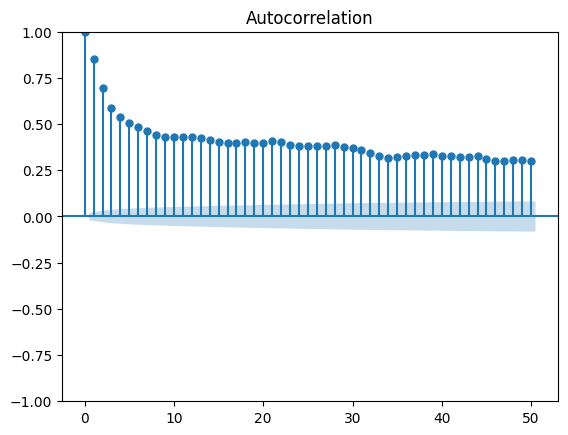

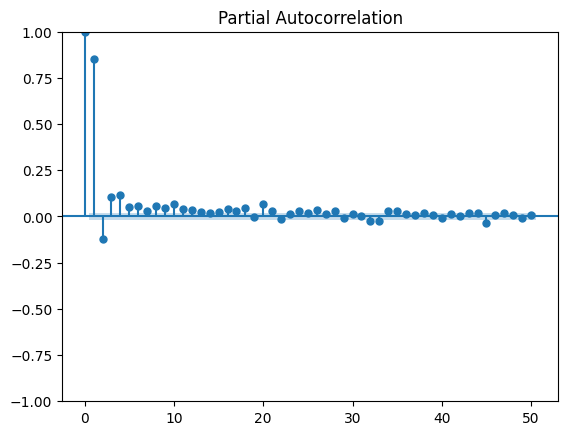

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 50  # how many time lags to check
plot_acf(df[kpi_col], lags=lags)
plot_pacf(df[kpi_col], lags=lags)
plt.show()


In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(df[kpi_col], lags=[10], return_df=True)
print(ljung_box_result)


         lb_stat  lb_pvalue
10  31274.819688        0.0


In [15]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df[kpi_col])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -8.302977050744294
p-value: 3.972302314541365e-13


In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare features (lag 1)
df['lag1'] = df[kpi_col].shift(1)
df = df.dropna()

# Train on ordered data
X = df[['lag1']].values
y = df[kpi_col].values
model = LinearRegression().fit(X, y)
ordered_score = model.score(X, y)

# Train on shuffled data
shuffled = df.sample(frac=1, random_state=42)
X_shuff = shuffled[['lag1']].values
y_shuff = shuffled[kpi_col].values
shuffled_score = model.fit(X_shuff, y_shuff).score(X_shuff, y_shuff)

print(f"Ordered R²: {ordered_score:.4f}, Shuffled R²: {shuffled_score:.4f}")


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.